# First approach: Dimensionality reduction using PCA

In this second approach, we will use PCA to reduce the dimensionality of the dataset. For this case, we will train the same models as in the first approach, but using the reduced dataset obtained by PCA. 

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


**Index**

- [Data loading](#Data-loading)
- [PCA Transformation](#PCA-Transformation)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Ensemble model](#Ensemble-model)
  - [Majority voting](#Majority-voting)
  - [Weighted voting](#Weighted-voting)
  - [Naive Bayes](#Naive-Bayes)
  - [Stacking](#Stacking)


## Data loading

In this second approach, we will preprocess ths data by applying PCA to reduce the dimensionality of the dataset. The number of components will be chosen by the explained variance ratio. First, we will perform the data loading and the PCA transformation to all the data in order to analize the results and choose the number of components. 

Then, to evaluate the models, we will use a **5-fold cross-validation** instead of splitting the data into training and test sets. By doing this, we will be able to compare the models in a more robust way and reduce the dependence on the randomness of the data split. So, the data passed to the training function will be the whole dataset before the PCA transformation. In this way, the PCA transformation will be applied in each fold of the cross-validation, avoiding data leakage.

Regarding to the metrics used to evaluate the models, we will use the **accuracy**, **precision**, **recall** and **f1-score**. The reason to not use only the accuracy is that the dataset is unbalanced and the accuracy can be misleading.


In [1]:
using DataFrames
using CSV
using Serialization

In [8]:
# Load custom functions from provided files
include("preprocessing.jl")
include("metrics.jl")
include("training.jl")
include("plotting.jl")

plot_2d (generic function with 2 methods)

In [3]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "dataset.csv"
data = CSV.read(dataset_path, DataFrame)
data[1:5, :]

Row,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Float64,String15
1,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout
2,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.0,0,0,6,6,6,13.6667,0,13.9,-0.3,0.79,Graduate
3,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.0,0,0,6,0,0,0.0,0,10.8,1.4,1.74,Dropout
4,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4,0,9.4,-0.8,-3.12,Graduate
5,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0,0,13.9,-0.3,0.79,Graduate


In [4]:
# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

In [5]:
inputs = Float32.(Matrix(inputs))

# Define the categories and their mapping
label_mapping = Dict("Dropout" => 0, "Graduate" => 1, "Enrolled" => 2)

# Encode the targets
targets_label_encoded = [label_mapping[label] for label in targets]

println("Encoded targets: ", targets_label_encoded[1:5])

# To decode later, create a reverse mapping
reverse_mapping = Dict(v => k for (k, v) in label_mapping)
decoded_targets = [reverse_mapping[code] for code in targets_label_encoded]

println("Decoded targets: ", decoded_targets[1:5])

Encoded targets: [0, 1, 0, 1, 1]
Decoded targets: ["Dropout", "Graduate", "Dropout", "Graduate", "Graduate"]


## PCA transformation

To select the optimal number of components to use in the PCA transformation, one of the most effective methods is to create a scree plot. This plot visualizes how the explained variance evolves as the number of components increases. The components are ordered according to their explained variance ratio, which is a measure of the proportion of the total variance in the dataset that each component captures.

In the scree plot, the x-axis represents the number of principal components, while the y-axis shows the amount of variance explained by each component. As you move to the right, the components typically explain less and less variance. The key idea is to identify the "elbow" point on the graph—this is the point where the explained variance starts to level off, indicating that adding more components results in marginal improvements in the variance explained.

By looking for this elbow, you can determine the number of components that retain most of the information (variance) without unnecessarily increasing the complexity of the model.


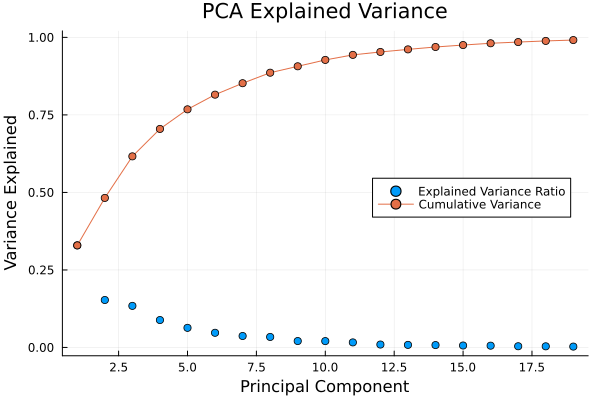

In [ ]:
function plot_pca_scree_plot(pca)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = cumsum(explained_variance_ratio)
    components = 1:length(explained_variance_ratio)

    
    p = plot(
        components,
        explained_variance_ratio,
        seriestype=:scatter,
        label="Explained Variance Ratio",
        xlabel="Principal Component",
        ylabel="Variance Explained",
        title="PCA Explained Variance",
        legend=:right,
        grid=true
    )

    plot!(
        components,
        cumulative_variance,
        seriestype=:line,
        label="Cumulative Variance",
        marker=:circle
    )
    
    display(p)
end

pca = PCA(n_components=0.99)
fit!(pca, inputs)
plot_pca_scree_plot(pca)

We can see that after the 12th component, the explained variance added starts to level off. So, we will use 12 components in the PCA transformation.

Now, before training the models, we will apply the PCA transformation to the whole data to analyze the results and try to explain a little bit about what the PCA transformation is doing to the data. In order to do so we create a heatmap, where the rows represent the original features and the columns represent the principal components. The values in the heatmap are the weights of the original features in the principal components, called the loadings. The loadings show how much each original feature contributes to each principal component.

In [85]:
function plot_pca_loadings(pca_model)
    
    loadings = pca_model.components_
    
    num_original_features = size(loadings, 2)
    
    h = heatmap(loadings, 
            xlabel="Original features", 
            ylabel="PCA components", 
            xticks=1:num_original_features, 
            yticks=1:size(loadings, 1), 
            color=:coolwarm,
            c=:RdBu,
            title="PCA Loadings",
            size=(800, 600)
    )

    display(h)
end

plot_pca_loadings (generic function with 1 method)

Variance explained: 0.9530237


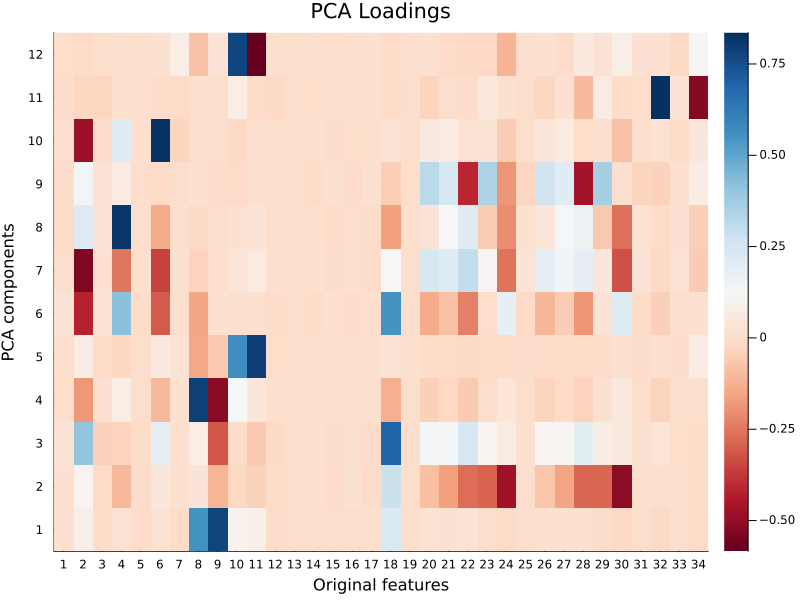

Feature 1: Marital status
Feature 2: Application mode
Feature 3: Application order
Feature 4: Course
Feature 5: Daytime/evening attendance
Feature 6: Previous qualification
Feature 7: Nacionality
Feature 8: Mother's qualification
Feature 9: Father's qualification
Feature 10: Mother's occupation
Feature 11: Father's occupation
Feature 12: Displaced
Feature 13: Educational special needs
Feature 14: Debtor
Feature 15: Tuition fees up to date
Feature 16: Gender
Feature 17: Scholarship holder
Feature 18: Age at enrollment
Feature 19: International
Feature 20: Curricular units 1st sem (credited)
Feature 21: Curricular units 1st sem (enrolled)
Feature 22: Curricular units 1st sem (evaluations)
Feature 23: Curricular units 1st sem (approved)
Feature 24: Curricular units 1st sem (grade)
Feature 25: Curricular units 1st sem (without evaluations)
Feature 26: Curricular units 2nd sem (credited)
Feature 27: Curricular units 2nd sem (enrolled)
Feature 28: Curricular units 2nd sem (evaluations)
Featu

In [87]:
pca = PCA(n_components=12)
fit_transform!(pca, inputs)
println("Variance explained: ", sum(pca.explained_variance_ratio_))
plot_pca_loadings(pca)

for (i, feature) in enumerate(names(data))
    println("Feature $i: $feature")
end

We observe that the total variance explained by the first 12 components is 0.95, meaning these 12 components account for 95% of the variance in the data. This is a strong result, as we are able to reduce the dimensionality of the dataset by 65% while retaining most of the information.

Upon examining the heatmap, several interesting observations emerge. For instance, features 8 and 9, which represent the mother's and father's qualifications, respectively, show similar weights. This is expected, as the overall qualification of the parents is likely more important than whether it is the mother’s or father’s qualification. A similar pattern is observed for features 10 and 11, which represent the mother's and father's occupations.

Another noteworthy observation is that all the features related to the curricular units (features 20 to 24 and 26 to 30) have similar weights. This suggests that the number of curricular units has a similar influence on academic performance, which we assume to be positive. Furthermore, we see a strong correlation between curricular units of the same type across two semesters, which is also expected, as the structure and content of these units are typically consistent across terms.